# Main Code

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from xml.etree import ElementTree
from xml.dom import minidom
import collections
import matplotlib as matplot
import seaborn as sns
import cv2
import shutil
from absl import app
from absl import flags
from absl import logging
import glob
import alignment
from alignment import compute_overlap
from alignment import align

In [7]:
#video_path
base_path = "/home/ubuntu/data/Users/maedahiroya/Library/Mobile_Documents/com_apple_CloudDocs/Lab/FY2019/04_MCR/20191019-20_tokushima/images_per_each_drive/"
# Root directory of the RCNN project
ROOT_DIR = os.path.abspath("../Mask_RCNN")
# result WIDTH and HEIGHT
WIDTH = 416
HEIGHT = 128
# calib_cam_to_cam.txt path
INPUT_TXT_FILE="./calib_cam_to_cam.txt"
# result seq length
SEQ_LENGTH = 3
# result step size
STEPSIZE = 1
#result output dir
OUTPUT_DIR = '/home/ubuntu/data/tokushima_result20200312'
#temp data dir
TEMP_DIR="/home/ubuntu/data/train_data_example20200312/"

In [8]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 
#delete this line in py file

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [9]:

data_dirs=[f.name for f in os.scandir(base_path) if not f.name.startswith('.')]


In [14]:
def make_dataset():
    #This function should be modified if you don't use KITTI dataset!
    global number_list,TEMP_DIR
    number_list=[]
    for dataset in data_dirs:
        data_year="2020"
        data_month="03"
        data_date="12"
        #Please designate these three variables if you don't use KITTI dataset
        IMAGE_DIR=base_path + dataset+ "/"
        #Please change IMAGE_DIR path if you don't use KITTI dataset
        
        file_names=[f.name for f in os.scandir(IMAGE_DIR) if not f.name.startswith('.')]
        OUTPUT_DIR1= TEMP_DIR+data_year+"_"+data_month+"_"+data_date+"/"+dataset+'/image_02/data'
        #Please change OUTPUT_DIR1 path if you don't use KITTI dataset
        if not os.path.exists(OUTPUT_DIR1+"/"):
            os.makedirs(OUTPUT_DIR1+"/")
        make_dataset1(OUTPUT_DIR1,file_names,dataset,IMAGE_DIR)
        OUTPUT_DIR2= TEMP_DIR+data_year+"_"+data_month+"_"+data_date+"/"+dataset+'/image_03/data'
        #Please change OUTPUT_DIR2 path if you don't use KITTI dataset
        if not os.path.exists(OUTPUT_DIR2+"/"):
            os.makedirs(OUTPUT_DIR2+"/")
        make_mask_images(OUTPUT_DIR2,file_names,dataset,IMAGE_DIR)
        OUTPUT_TXT_FILE=TEMP_DIR+data_year+"_"+data_month+"_"+data_date+"/calib_cam_to_cam.txt"
        #Please change OUTPUT_TXT_FILE path if you don't use KITTI dataset
        shutil.copyfile(INPUT_TXT_FILE, OUTPUT_TXT_FILE)
    
    
    run_all(file_names)
    TXT_RESULT_PATH=OUTPUT_DIR
    with open(TXT_RESULT_PATH+"/train.txt", mode='w') as f:
        f.write('\n'.join(number_list))
        

In [27]:
def make_dataset1(OUTPUT_DIR1,file_names,dataset,IMAGE_DIR):
    for i in range(0,len(file_names)):        
        image_file=IMAGE_DIR + file_names[i]
        img = cv2.imread(image_file)
        img=cv2.resize(img,(416,416))
        img = img[96 : 224, 0 : 416]       
        if not os.path.exists(OUTPUT_DIR1):
            os.makedirs(OUTPUT_DIR1)
        cv2.imwrite(OUTPUT_DIR1 + '/' + file_names[i] + '.jpg', img)

In [28]:
def make_mask_images(OUTPUT_DIR2,file_names,dataset,IMAGE_DIR):
    for i in range(0,len(file_names)):   
        image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names[i]))
        image=cv2.resize(image,(416,416))
        image = image[96 : 224, 0 : 416]              
        # Run detection
        results = model.detect([image], verbose=1)
        r = results[0]
        # Prepare black image
        mask_base = np.zeros((image.shape[0],image.shape[1],image.shape[2]),np.uint8)
        after_mask_img = image.copy()
        color = (10, 10, 10) #white
        number_of_objects=len(r['masks'][0,0])
        mask_img=mask_base


        for j in range(0,number_of_objects):

            mask = r['masks'][:, :, j]

            mask_img = visualize.apply_mask(mask_base, mask, color,alpha=1)
        
            if not os.path.exists(OUTPUT_DIR2):
                os.makedirs(OUTPUT_DIR2)
        cv2.imwrite(OUTPUT_DIR2 + '/' + file_names[i] + '.jpg',mask_img)

In [29]:
def get_line(file, start):
    file = open(file, 'r')
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    ret = None
    for line in lines:
        nline = line.split(': ')
        if nline[0]==start:
            ret = nline[1].split(' ')
            ret = np.array([float(r) for r in ret], dtype=float)
            ret = ret.reshape((3,4))[0:3, 0:3]
            break
    file.close()
    return ret

In [30]:
def crop(img, segimg, fx, fy, cx, cy):
    # Perform center cropping, preserving 50% vertically.
    middle_perc = 0.50
    left = 1-middle_perc
    half = left/2
    a = img[int(img.shape[0]*(half)):int(img.shape[0]*(1-half)), :]
    aseg = segimg[int(segimg.shape[0]*(half)):int(segimg.shape[0]*(1-half)), :]
    cy /= (1/middle_perc)

    # Resize to match target height while preserving aspect ratio.
    wdt = int((128*a.shape[1]/a.shape[0]))
    x_scaling = float(wdt)/a.shape[1]
    y_scaling = 128.0/a.shape[0]
    b = cv2.resize(a, (wdt, 128))
    bseg = cv2.resize(aseg, (wdt, 128))

    # Adjust intrinsics.
    fx*=x_scaling
    fy*=y_scaling
    cx*=x_scaling
    cy*=y_scaling

    # Perform center cropping horizontally.
    remain = b.shape[1] - 416
    cx /= (b.shape[1]/416)
    c = b[:, int(remain/2):b.shape[1]-int(remain/2)]
    cseg = bseg[:, int(remain/2):b.shape[1]-int(remain/2)]

    return c, cseg, fx, fy, cx, cy

#the content of this function doesn't affect the result

In [31]:
def run_all(file_names):
    global number_list,OUTPUT_DIR,TEMP_DIR
    ct = 0
  
  
    if not OUTPUT_DIR.endswith('/'):
        OUTPUT_DIR = OUTPUT_DIR + '/'

    for d in glob.glob(TEMP_DIR+'*/'):
        date = d.split('/')[-2]
        file_calibration = d + 'calib_cam_to_cam.txt'
        calib_raw = [get_line(file_calibration, 'P_rect_02'), get_line(file_calibration, 'P_rect_03')]

        for d2 in glob.glob(d + '*/'):
            DIR_NAME = d2.split('/')[-2]
            if not os.path.exists(OUTPUT_DIR + DIR_NAME +"/"):
                os.makedirs(OUTPUT_DIR + DIR_NAME +"/")
            print('Processing sequence', DIR_NAME)
            for subfolder in ['image_02/data']:
                ct = 1               
                calib_camera = calib_raw[0] if subfolder=='image_02/data' else calib_raw[1]
                folder = d2 + subfolder
                #files = glob.glob(folder + '/*.png')
                files = glob.glob(folder + '/*.jpg')
                files = [file for file in files if not 'disp' in file and not 'flip' in file and not 'seg' in file]
                files = sorted(files)
                for i in range(SEQ_LENGTH, len(files)+1, STEPSIZE):
                    imgnum = str(ct).zfill(10)
                    big_img = np.zeros(shape=(HEIGHT, WIDTH*SEQ_LENGTH, 3))
                    wct = 0

                    for j in range(i-SEQ_LENGTH, i):  # Collect frames for this sample.
                        img = cv2.imread(files[j])
                        ORIGINAL_HEIGHT, ORIGINAL_WIDTH, _ = img.shape

                        zoom_x = WIDTH/ORIGINAL_WIDTH
                        zoom_y = HEIGHT/ORIGINAL_HEIGHT

                        # Adjust intrinsics.
                        calib_current = calib_camera.copy()
                        calib_current[0, 0] *= zoom_x
                        calib_current[0, 2] *= zoom_x
                        calib_current[1, 1] *= zoom_y
                        calib_current[1, 2] *= zoom_y

                        calib_representation = ','.join([str(c) for c in calib_current.flatten()])

                        img = cv2.resize(img, (WIDTH, HEIGHT))
                        big_img[:,wct*WIDTH:(wct+1)*WIDTH] = img
                        wct+=1
                    cv2.imwrite(OUTPUT_DIR  + DIR_NAME + '/' +  imgnum + '.png', big_img)
                    f = open(OUTPUT_DIR  + DIR_NAME + '/' + imgnum + '_cam.txt', 'w')
                    f.write(calib_representation)
                    f.close()
                    ct+=1
                    
            for subfolder in ['image_03/data']:
                ct = 1
                calib_camera = calib_raw[0] if subfolder=='image_02/data' else calib_raw[1]
                folder = d2 + subfolder
                #files = glob.glob(folder + '/*.png')
                files = glob.glob(folder + '/*.jpg')
                files = [file for file in files if not 'disp' in file and not 'flip' in file and not 'seg' in file]
                files = sorted(files)
                for i in range(SEQ_LENGTH, len(files)+1, STEPSIZE):
                    imgnum = str(ct).zfill(10)
                    big_img = np.zeros(shape=(HEIGHT, WIDTH*SEQ_LENGTH, 3))
                    wct = 0

                    for j in range(i-SEQ_LENGTH, i):  # Collect frames for this sample.
                        img = cv2.imread(files[j])
                        ORIGINAL_HEIGHT, ORIGINAL_WIDTH, _ = img.shape

                        zoom_x = WIDTH/ORIGINAL_WIDTH
                        zoom_y = HEIGHT/ORIGINAL_HEIGHT

                        # Adjust intrinsics.
                        calib_current = calib_camera.copy()
                        calib_current[0, 0] *= zoom_x
                        calib_current[0, 2] *= zoom_x
                        calib_current[1, 1] *= zoom_y
                        calib_current[1, 2] *= zoom_y

                        calib_representation = ','.join([str(c) for c in calib_current.flatten()])

                        img = cv2.resize(img, (WIDTH, HEIGHT))
                        big_img[:,wct*WIDTH:(wct+1)*WIDTH] = img
                        wct+=1
                    #cv2.imwrite(OUTPUT_DIR + seqname + '/' + imgnum + '.png', big_img)
                    #f = open(OUTPUT_DIR + seqname + '/' + imgnum + '_cam.txt', 'w')
                    cv2.imwrite(OUTPUT_DIR   +DIR_NAME + '/' + imgnum + '-fseg.png', big_img)
                    f = open(OUTPUT_DIR  + DIR_NAME + '/' + imgnum + '_cam.txt', 'w')
                    number_list.append(DIR_NAME+" "+imgnum)
                    f.write(calib_representation)
                    f.close()
                    ct+=1

In [20]:
#make_dataset()

#Be careful! It takes much time!

# Mask RCNN Demo

Processing 1 images
image                    shape: (128, 416, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


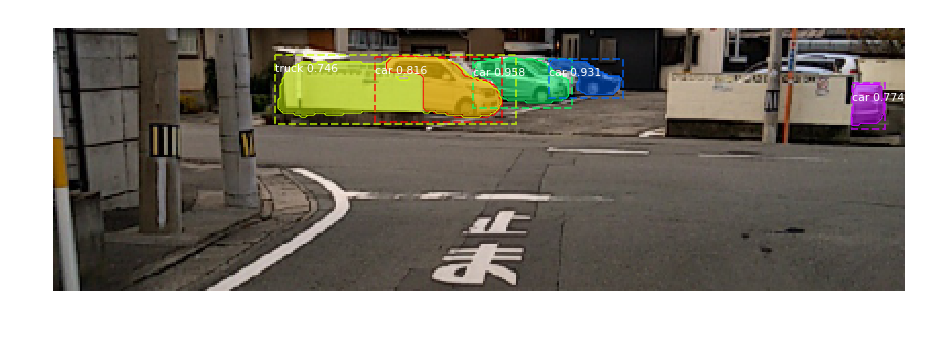

elapsed_time:1.3031961917877197[sec]


In [32]:
import time

dataset=data_dirs[0]
data_year="2020"
data_month="03"
data_date="12"


IMAGE_DIR=base_path + dataset+ "/"

file_names=[f.name for f in os.scandir(IMAGE_DIR) if not f.name.startswith('.')]


start = time.time()

image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names[10]))

# Run detection
image=cv2.resize(image,(416,416))
IMAGE_DIR=base_path + dataset+ "/"
image = image[96 : 224, 0 : 416]         
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

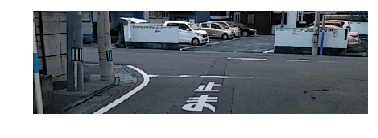

In [33]:
import cv2

color_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(6, 6))
axes.imshow(color_img)
axes.axis('off')
plt.show()

In [34]:
#prepare all black image
mask_base = np.zeros((image.shape[0],image.shape[1],image.shape[2]),np.uint8)
after_mask_img = image.copy()
color = (10, 10, 10) #white

#get mask data from the result

number_of_objects=len(r['masks'][0,0])

mask_img=mask_base
for i in range(0,number_of_objects):

    mask = r['masks'][:, :, i]

    mask_img = visualize.apply_mask(mask_base, mask, color,alpha=1)
    #To make the binary image, alpha is set to be 1
    

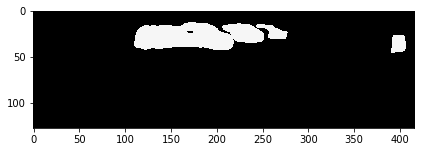

In [35]:
skimage.io.imshow(mask_img)
plt.show()